# Sec 1
Import libs used for Chinese topic modelling (jieba, gensim, and pyLDAvis)

In [1]:
# Chinese LDA for plot summaries
# Based on https://blog.csdn.net/weixin_39876856/article/details/111646357
# and https://www.cnblogs.com/zongfa/p/9556471.html
import jieba
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import json
import urllib.request

Load film data from main JSON and initialise stop word list

NAME_STOPPING_SOURCE can be "Entities" (stop 615 names detected by NamedEntity Recognition), "Characters" (stop all 7150 fictional character names documented in The Catalogue of Chinese Art Films), or "None"

"Characters" might cause slowness but is the most accurate one.

In [2]:
NAME_STOPPING_SOURCE = "Characters"

with open("../metadata-all.json") as f:
    films = json.load(f)["films"]

print("Total number of films: ", len(films))

# Print all films in the dataset to check if it is loaded correctly
for [i, film] in enumerate(films):
	print("{} [{}] ({})".format(film["title"], film["translated"], film["year"]))
        
def stop_words():
	stopwords = []
	# Stop word for Chiense, list 1
	url_data = urllib.request.urlopen("https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt")
	for line in url_data:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# Stop word for Chiense, list 2
	url_data2 = urllib.request.urlopen("https://raw.githubusercontent.com/wanghaing/project-model-LDA/master/data/stop_word/stop_word%EF%BC%88utf8%EF%BC%89.txt")
	for line in url_data2:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# An extra stop word list designed for old Chinese film plot summaries
	extra_list = open("./extra-stopwords.txt", "r", encoding="utf-8")
	for line in extra_list:
		if line not in stopwords:
			stopwords.append(line)
	
	if NAME_STOPPING_SOURCE == "Characters":
		entity_list = open("./ultimate_character_list(bianmu).txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)
	elif NAME_STOPPING_SOURCE == "Entities":
		# A list of entity names generated from the film metadata with Baidi API
		# Adding this list may decrease the readability of extracted topics
		entity_list = open("./plot_entities.txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)

	stopwords = [x.strip() for x in stopwords]
	print("{} stop words loaded".format(len(stopwords)))
	return stopwords

def tokenize(text, stop_words):
	#Remove all spaces, {LINE_CUT}, {COMMA}, {QUOTE} symbols in the text
	text = text.replace(" ", "").replace("{LINE_CUT}", "").replace("{COMMA}", "").replace("{QUOTE}", "").replace("”", "").replace("\n", "").replace('“', "")

	segmented = jieba.cut(text.strip())
	output = ""
	for seg in segmented:
		# Add one segment only if it is not a stop word and longer than 1 character
		if seg not in stop_words and len(seg) > 1:
				output += seg + " "
	return output

stop_words = stop_words()

Total number of films:  732
桥 [The Bridge] (1949)
回到自己队伍来 [Return to Our Army] (1949)
光芒万丈 [Light Spreads Everywhere] (1949)
中华女儿 [Daughters of China] (1949)
白衣战士 [Fighter in White] (1949)
无形的战线 [The Invisible Front Line] (1949)
表 [The Watch (aka An Orphan on the Streets)] (1949)
二百五小传 [The Story of a Foolish Man (aka The Heroic Opera Performer)] (1949)
乌鸦与麻雀 [Crows and Sparrows] (1949)
三毛流浪记 [The Story of “Three Hair” the Vagrant] (1949)
赵一曼 [Zhao Yiman] (1950)
光荣人家 [Honorable Family] (1950)
卫国保家 [Protecting Home Through the Nation] (1950)
红旗歌 [Song of the Red Flag] (1950)
钢铁战士 [Steeled Fighters] (1950)
高歌猛进 [Aggressively Moving Forward] (1950)
刘胡兰 [Liu Hulan] (1950)
辽远的乡村 [A Remote Village] (1950)
内蒙人民的胜利 [Victory for the People of Inner Mongolia] (1950)
白毛女 [The White-Haired Girl] (1950)
人民的战士 [People’s Soldiers] (1950)
保卫胜利果实 [Guarding the Fruits of Victory] (1950)
在前进的道路上 [On the Progressive Road] (1950)
吕梁英雄 [Heros of Lvliang] (1950)
鬼神不灵 [Ghosts Don’t Exist] (1950)
民主青年进行曲 [Demo

# Sec 2
Setting the setting(s) in the cell below to adjust the results

In [3]:
# Whether all films or only features should be analysed
# (Disabling this option seems to result in higher coherence scores)
FEATURE_FILM_ONLY = False

# Whether to apply the topic model per word or per topic
# An attribute in LDA model
APPLY_PER_WORD_TOPIC = True

Tokenise the plot summaries and print all

In [4]:
results = []

i = 0

for film in films:
	if FEATURE_FILM_ONLY and film["filmType"] != "Feature":
		print("Skipping film {} as it is not a feature film".format(film["title"]))
		continue
	plot = film["plot"]
	str = tokenize(plot, stop_words)
	if str != "":
		results.append([i, str])
		i += 1

print("\nTotal number of film plots loaded: ", len(results))
results = [n[1].split(" ")[:-1] for n in results]

Building prefix dict from the default dictionary ...
2023-05-05 13:30:48,980 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/9z/59hfx__d1z5g44xgvv4r0gv40000gn/T/jieba.cache
2023-05-05 13:30:48,982 : DEBUG : Loading model from cache /var/folders/9z/59hfx__d1z5g44xgvv4r0gv40000gn/T/jieba.cache
Loading model cost 0.319 seconds.
2023-05-05 13:30:49,301 : DEBUG : Loading model cost 0.319 seconds.
Prefix dict has been built successfully.
2023-05-05 13:30:49,302 : DEBUG : Prefix dict has been built successfully.



Total number of film plots loaded:  732


Initialise "The Bag of Words" and LDA based on the tokenised plot summaries

In [5]:
word_bag = corpora.Dictionary(results)
corpus = [word_bag.doc2bow(text) for text in results]

#print([[(word_bag[id], freq) for id, freq in cp] for cp in corpus[:1]])

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
										   id2word=word_bag,
                                           num_topics=40,
                                           per_word_topics=APPLY_PER_WORD_TOPIC)

#pprint(lda_model.print_topics(num_words=20))

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=results, dictionary=word_bag, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.741510424966206

Coherence Score:  0.4570550879992975


Filter topics
(Suggested TOPIC_RANGE=46; TOPIC_STEP=5)
(Or TOPIC＿RANGE＝21; TOPIC_STEP=2 for more compact results when FEATURE_FILM_ONLY is off)

In [6]:
TOPIC_RANGE = 21
TOPIC_STEP = 1

coherence_values = []
model_list = []
for num_topics in range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP):
	model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=word_bag, num_topics=num_topics,
					 						per_word_topics=APPLY_PER_WORD_TOPIC,
											iterations=600, eval_every=None, eta='auto')
	model_list.append(model)
	coherencemodel = CoherenceModel(model=model, texts=results, dictionary=word_bag, coherence='c_v')
	coherence_values.append(round(coherencemodel.get_coherence(), 3))


# Sec 3
## Results Output #1 (Parallel):
Get the best range of topic numbers

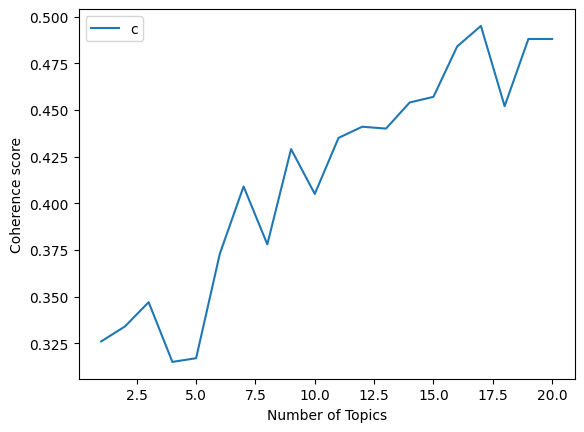

In [7]:
# Show graph
x = range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Sec 3
## Results Output #2 (Parallel):
Visualise attributes of optimal model

In [8]:
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20))

print("\n")

[(0,
  '0.003*"斗争" + 0.003*"生产" + 0.002*"代表队" + 0.002*"文艺" + 0.002*"两人" + '
  '0.002*"解放" + 0.002*"途中" + 0.002*"学生" + 0.002*"纱厂" + 0.002*"逮捕" + 0.002*"只得" '
  '+ 0.002*"得知" + 0.002*"职工" + 0.002*"计划" + 0.002*"体育" + 0.002*"阴谋" + '
  '0.002*"紫贵" + 0.002*"成立" + 0.002*"工作" + 0.002*"老爷"'),
 (1,
  '0.004*"工作" + 0.003*"广州" + 0.002*"矿工" + 0.002*"斗争" + 0.002*"解放后" + '
  '0.002*"带领" + 0.002*"展开" + 0.002*"英国" + 0.002*"纵队" + 0.002*"文广" + 0.002*"生产" '
  '+ 0.002*"人瑞" + 0.002*"报仇" + 0.002*"大跃进" + 0.002*"合作社" + 0.002*"支持" + '
  '0.002*"困难" + 0.002*"组织" + 0.002*"前往" + 0.002*"两个"'),
 (2,
  '0.005*"革命" + 0.004*"教育" + 0.003*"劳动" + 0.003*"生产" + 0.002*"三两" + 0.002*"学生" '
  '+ 0.002*"工作" + 0.002*"反革命" + 0.002*"黄涛" + 0.002*"解放" + 0.002*"官弼" + '
  '0.002*"秋容" + 0.002*"小图" + 0.002*"共产党" + 0.002*"农村" + 0.002*"回到" + '
  '0.002*"思想" + 0.002*"离开" + 0.002*"农业" + 0.002*"批评"'),
 (3,
  '0.004*"生产" + 0.003*"阴谋" + 0.003*"思想" + 0.003*"工作" + 0.002*"玉川" + 0.002*"生活" '
  '+ 0.002*"风筝" + 0.002*"揭露" + 0.002*"反动派" + 0.002*"率领" 

In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, word_bag)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.118360  0.045144       1        1  10.680255
8     -0.048148 -0.015040       2        1   7.438910
13    -0.092419  0.037332       3        1   6.893320
14    -0.005892  0.068824       4        1   6.751522
16    -0.035081 -0.044142       5        1   6.710510
0     -0.000707  0.020942       6        1   6.561769
3      0.009587 -0.117594       7        1   6.077201
11     0.142422  0.110334       8        1   6.064279
4      0.010637  0.015827       9        1   5.513311
12     0.060436  0.001650      10        1   5.306299
2     -0.028573 -0.013569      11        1   5.254809
6     -0.036436  0.008220      12        1   5.230116
7     -0.006356 -0.013871      13        1   4.989181
1     -0.018203 -0.022367      14        1   4.901228
15     0.064625  0.039346      15        1   4.153525
5      0.015370  0.006938      16        1   4.056329
10     0.087099 -0.127975      17        1   3.417436, topic_info=     Term       Freq      Total Category  logprob  loglift
3938   陈士  15.000000  15.000000  Default  30.0000  30.0000
1717  游击队  76.000000  76.000000  Default  29.0000  29.0000
298    演出  36.000000  36.000000  Default  28.0000  28.0000
8048   文举  10.000000  10.000000  Default  27.0000  27.0000
2334  合作社  56.000000  56.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
210    发生   3.044449  47.595169  Topic17  -6.3273   0.6269
191    阴谋   3.041604  50.888451  Topic17  -6.3282   0.5590
600    错误   3.043838  60.408990  Topic17  -6.3275   0.3883
19     思想   3.043756  84.671494  Topic17  -6.3275   0.0506
164    途中   2.700070  42.231928  Topic17  -6.4473   0.6264

[1088 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
13964     11  0.692458  5311
3156      15  0.731511    一区
1017       1  0.153603    一场
1017       2  0.038401    一场
1017       3  0.076802    一场
...      ...       ...   ...
90        14  0.031304    鼓励
90        15  0.031304    鼓励
90        17  0.093912    鼓励
7033       5  0.885717    龙袍
2456       3  0.895873   龙须沟

[3129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 14, 15, 17, 1, 4, 12, 5, 13, 3, 7, 8, 2, 16, 6, 11])

In [10]:
def format_topics_sentences(ldamodel, corpus, texts):
    i = 0
    for item in corpus:
        f_key = films[i]["key"]
        doc_tops = ldamodel.get_document_topics(item, minimum_probability=0.0)
        new_list = sorted(doc_tops, key=lambda x: x[1], reverse=True)
        # Iterate the new list and add the topics with highest probabilities to the list
        j = 0
        max_prob = new_list[0][1]
        
        dominant_tops = []
        
        while j < len(new_list):
            if new_list[j][1] >= max_prob:
                    j += 1
                    dominant_tops.append(new_list[j][0])
            else:
                    break

        #get_document_topics = [dominant_top]
        print("|||FILM:{}|||TOPICS:{}|||TEXT:{}".format(f_key, dominant_tops, texts[i]))
        i += 1
	

format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=results)

|||FILM:qiao|||TOPICS:[2]|||TEXT:['一九四七年', '东北', '铁路', '工厂', '支援', '解放战争', '接受', '抢修', '松花江', '铁桥', '看不到', '群众', '力量', '缺乏', '信心', '雇佣', '思想', '制造', '修复', '铁桥', '铆钉', '修复', '炼钢炉', '创造', '耐火砖', '白云石', '办法', '试验', '成功', '克服', '一系列', '困难', '制出', '修复', '铁桥', '铆钉', '赶修', '铁桥', '铁路', '工厂', '响应', '上级', '号召', '修桥', '工作', '江水', '解冻', '大桥', '修复']
|||FILM:hui dao zi ji dui wu lai|||TOPICS:[8]|||TEXT:['解放战争', '时期', '蒋军', '蒋军', '抢掠', '蒋军', '毒打', '围攻', '吴城时', '宣传教育', '深受感动', '前往', '城里', '说服', '一道', '鼓动', '被迫', '当兵', '蒋军', '投诚', '蒋军', '联合', '抓起', '欺压', '蒋军', '投诚']
|||FILM:guang mang wan zhang|||TOPICS:[4]|||TEXT:['东北', '发电厂', '蒋军', '逃窜', '破坏', '失业', '解放后', '人民政府', '修复', '发电厂', '响应号召', '党的领导', '团结', '群众', '工作', '发电机', '固定', '磁铁', '腐蚀', '提议', '办法', '克服', '技术人员', '股长', '和方', '负责', '鼓励', '工友', '合作', '克服困难', '修好', '发电机', '潜伏', '破坏', '气馁', '股长', '和方', '商量', '解决', '办法', '股长', '和方', '很受', '感动', '一道', '发电机', '修复', '保证', '全市', '供电']
|||FILM:zhong hua nv er|||TOPICS:[9]|||TEXT:['一九三六年', '东北', '不堪', '忍受', '日寇', 